In [1]:
%matplotlib inline
from ztfquery import query
import numpy as np
import datetime

In [2]:
def get_ztf_data(date=None):
    """Function to grab data for a given date using ztfquery. 
    Date should be given in format YYYYMMDD, with the day being the UT day for the END of the night.
    By default, today is selected
    """
    if date is None:
        print("No date specified. Assuming today.")
        now = datetime.datetime.now()
        date = now.strftime("%Y%m%d")
    try:
        return query.NightSummary(date)
    except IndexError:
        print("No ZTF observations for night", date)
        return None

In [3]:
def stack_nightly_summaries(start_date=None, end_date=None):
    
    date_format = "%Y%m%d"
    
    if start_date is None:
        now = datetime.datetime.now()
        start_time = now - datetime.timedelta(days=30)
    else:
        start_time = datetime.datetime.strptime(start_date, date_format).time()
    if end_date is None:
        end_time = datetime.datetime.now()
    else:
        end_time = datetime.datetime.strptime(end_date, date_format).time()
        
    delta_t = (end_time - start_time).days
    
    end_date = end_time.strftime(date_format)
    
    ns = None
    
    for n_days in range(0, delta_t + 1):
        night = (start_time + datetime.timedelta(days=n_days)).strftime(date_format)
        new_ns = get_ztf_data(night)
        if ns is None:
            ns = new_ns

        if new_ns is not None:
            ns.data = ns.data.append(new_ns.data)
        
    if ns is None:
        print("No nightly sumaries found for any of the nights between {0} and {1}".format(start_date, end_date))
    else:
        ns.show_gri_fields()

In [4]:
# stack_nightly_summaries()

In [5]:
# ns = get_ztf_data()

In [22]:
import datetime
from tqdm import tqdm
from ztfquery.query import _ZTFTableHandler_

class MultiNightSummary(_ZTFTableHandler_):
    
    def __init__(self, start_date=None, end_date=None):
        self.nights = self.find_nights(start_date, end_date)
        
        print("Using {0} Nightly Sumaries between {1} and {2}".format(
            len(self.nights), self.nights[0], self.nights[-1]))
        
        self.data, self.missing_nights = self.stack_nights()
        
        print("Of these, {0} nights are missing because ZTF did not observe.".format(len(self.missing_nights)))
        
    @staticmethod
    def find_nights(start_date=None, end_date=None):
        date_format = "%Y%m%d"
    
        if start_date is None:
            now = datetime.datetime.now()
            start_time = now - datetime.timedelta(days=30)
        else:
            start_time = datetime.datetime.strptime(start_date, date_format).time()
        if end_date is None:
            end_time = datetime.datetime.now()
        else:
            end_time = datetime.datetime.strptime(end_date, date_format).time()
            
        if start_time > end_time:
            raise ValueError("Start time {0} occurs after end time {1}.".format(start_time, end_time))

        delta_t = (end_time - start_time).days
        
        dates = [(start_time + datetime.timedelta(days=x)).strftime(date_format) for x in range(0, delta_t + 1)]
        
        return dates
        
    def stack_nights(self):
        ns = None
        missing_nights = []
    
        for night in tqdm(self.nights):
            new_ns = self.get_ztf_data(night)
            
            if ns is None:
                ns = new_ns

            if new_ns is not None:
                ns.data = ns.data.append(new_ns.data)
            else:
                missing_nights.append(night)
                
        return ns.data, missing_nights
    
    @staticmethod
    def get_ztf_data(date=None):
        """Function to grab data for a given date using ztfquery. 
        Date should be given in format YYYYMMDD, with the day being the UT day for the END of the night.
        By default, today is selected. Returns a NightSummary if one is available, or None otherwise 
        (None is returned if there are no ZTF observations).
        """
        if date is None:
            print("No date specified. Assuming today.")
            now = datetime.datetime.now()
            date = now.strftime("%Y%m%d")
        try:
            return query.NightSummary(date)
        # query returns an index error is no ztf data is found
        except IndexError:
            return None

In [23]:
mns = MultiNightSummary()

  0%|          | 0/31 [00:00<?, ?it/s]

Using 31 Nightly Sumaries between 20190525 and 20190624


100%|██████████| 31/31 [00:33<00:00,  1.09s/it]

Of these, 4 are missing because ZTF did not observe


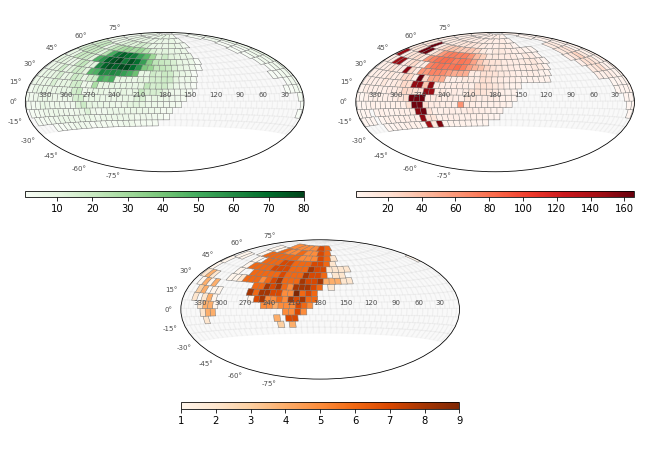

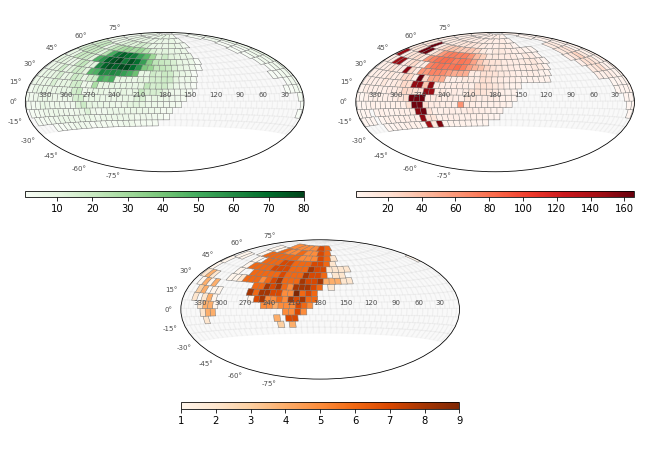

In [26]:
mns.show_gri_fields()